In [1]:
import sys
sys.path.append("..")
from pathlib import Path
from src.utils.datatool import read_jsonlines
from src.dataset.trance import Event
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Event(split="test", read_raw_image=True)

def summary_result(result, dataset):
    idx = result["sample_id"]
    init_img_name, fin_img_name, init_desc, fin_desc, trans, _ = dataset.extract_info(idx)

    path_init_img = dataset.image_root / init_img_name
    path_fin_img = dataset.image_root / fin_img_name

    gt = dataset.vectorizer.vec2multitrans(result["target"])
    pred = dataset.vectorizer.vec2multitrans(result["pred"])

    pred_objs = list(sorted([trans[0] for trans in result["pred"]]))
    pred_actions = list(sorted([trans[1] for trans in result["pred"]]))
    gt_objs = list(sorted([trans[0] for trans in result["target"]]))
    gt_actions = list(sorted([trans[1] for trans in result["target"]]))

    obj_all_correct_failure = (not result["correct"]) and (pred_objs == gt_objs)
    action_all_correct_failure = (not result["correct"]) and (pred_actions == gt_actions)
    set_failure = obj_all_correct_failure and action_all_correct_failure

    pred_trans = set([f"{t[0]}.{t[1]}" for t in result["pred"]])
    gt_trans = set([f"{t[0]}.{t[1]}" for t in result["target"]])

    hit_rate = len(pred_trans & gt_trans) / len(gt_trans)

    pred_objs = set([t[0] for t in result["pred"]])
    gt_objs = set([t[0] for t in result["target"]])

    hit_obj_rate = len(pred_objs & gt_objs) / len(gt_objs)

    pred_actions = set([t[1] for t in result["pred"]])
    gt_actions = set([t[1] for t in result["target"]])

    hit_action_rate = len(pred_actions & gt_actions) / len(gt_actions)

    small_obj_failure = False
    position_failure = False
    non_position_failure = False

    if not result["correct"]:

        non_hit_trans = (pred_trans - gt_trans) | (gt_trans - pred_trans)

        for t in non_hit_trans:

            obj = int(t.split(".")[0])
            action = int(t.split(".")[1])

            if not small_obj_failure and (
                init_desc[obj]["size"] == "small"
                or fin_desc[obj]["size"] == "small"
            ):
                small_obj_failure = True

            t_dict = dataset.vectorizer.vec2trans(obj, action)
            t_attr = t_dict["attr"]

            if not position_failure and t_attr == "position":
                position_failure = True

            if not non_position_failure and t_attr != "position":
                non_position_failure = True

    info = {
        "idx": idx,
        "gt": gt,
        "pred": pred,
        "path_init_img": path_init_img,
        "path_fin_img": path_fin_img,
        "dist": result["dist"],
        "step": len(result["target"]),
        "correct": result["correct"],
        "loose_correct": result["loose_correct"],
        "err_overlap": result["err_overlap"],
        "err_invalid_position": result["err_invalid_position"],
        "obj_all_correct_failure": obj_all_correct_failure,
        "action_all_correct_failure": action_all_correct_failure,
        "set_failure": set_failure,
        "small_obj_failure": small_obj_failure,
        "position_failure": position_failure,
        "non_position_failure": non_position_failure,
        "hit_rate": hit_rate,
        "hit_obj_rate": hit_obj_rate,
        "hit_action_rate": hit_action_rate,
    }

    return info

def visualize_result(result, dataset, gap=2, save_path="init_fin.png"):
    info = summary_result(result, dataset)

    init_img = Image.open(info["path_init_img"])
    fin_img = Image.open(info["path_fin_img"])

    img = Image.new("RGBA", (init_img.width + gap + fin_img.width, init_img.height))
    img.paste(init_img, (0, 0))
    img.paste(fin_img, (init_img.width + gap, 0))
    img.save(save_path)
    plt.imshow(np.array(img))
    # set matplotlib high resolution
    plt.rcParams["figure.dpi"] = 300
    plt.axis("off")
    plt.show()

    print(f"GT ({len(info['gt'])} steps):")
    for trans in info["gt"]:
        print(f"- {trans['obj']} {trans['pair']}")

    print(f"Pred ({len(info['pred'])} steps):")
    for trans in info["pred"]:
        print(f"- {trans['obj']} {trans['pair']}")

    print("--------------------")
    print(f"Index: {info['idx']}")
    print(f"Distance: {info['dist']}")
    print(f"Correct: {info['correct']}")
    print(f"Loose correct: {info['loose_correct']}")

    print("--------------------")
    print(f"Hit rate: {info['hit_rate']}")
    print(f"Hit object rate: {info['hit_obj_rate']}")
    print(f"Hit action rate: {info['hit_action_rate']}")

    print("--------------------")
    print(f"Overlap: {info['err_overlap']}")
    print(f"Invalid Position: {info['err_invalid_position']}")
    print(f"Object all correct failure: {info['obj_all_correct_failure']}")
    print(f"Action all correct failure: {info['action_all_correct_failure']}")
    print(f"Set failure: {info['set_failure']}")
    print(f"Small object failure: {info['small_obj_failure']}")
    print(f"Position failure: {info['position_failure']}")
    print(f"Non-position failure: {info['non_position_failure']}")
    print("--------------------")


def summary_failures(failures):

    failure_analysis = {
        "all": list(range(len(results))),
        "loose_failures": [r["idx"] for r in failures if r["loose_correct"]],
        "set_failures": [r["idx"] for r in failures if r["set_failure"]],
        "obj_all_correct_failures": [
            r["idx"] for r in failures if r["obj_all_correct_failure"]
        ],
        "action_all_correct_failures": [
            r["idx"] for r in failures if r["action_all_correct_failure"]
        ],
        "overlap_failures": [r["idx"] for r in failures if r["err_overlap"]],
        "move_out_failures": [
            r["idx"] for r in failures if r["err_invalid_position"]
        ],
        "hit_rates": [r["hit_rate"] for r in failures],
        "hit_obj_rates": [r["hit_obj_rate"] for r in failures],
        "hit_action_rates": [r["hit_action_rate"] for r in failures],
        "small_obj_failures": [
            r["idx"] for r in failures if r["small_obj_failure"]
        ],
        "position_failures": [r["idx"] for r in failures if r["position_failure"]],
        "non_position_failures": [
            r["idx"] for r in failures if r["non_position_failure"]
        ],
        "failure_steps": [r["step"] for r in failures],
        "failure_dist": [r["dist"] for r in failures],
    }


    plt.hist(
        failure_analysis["failure_steps"], rwidth=0.8, bins=np.arange(1, 6) - 0.5
    )
    plt.title("Failure steps")
    plt.show()

    plt.hist(
        failure_analysis["failure_dist"], rwidth=0.8, bins=np.arange(1, 10) - 0.5
    )
    plt.title("Failure distance")
    plt.show()


    print(f"Total samples: {len(results)}")
    print(
        f"Failures: {len(failures)}, error rate: {len(failures) / len(results) * 100:.2f}%"
    )
    print("--------------------")
    print(f"Trans hit rate: {np.mean(failure_analysis['hit_rates']) * 100:.2f}%")
    print(f"Obj hit rate: {np.mean(failure_analysis['hit_obj_rates']) * 100:.2f}%")
    print(
        f"Action hit rate: {np.mean(failure_analysis['hit_action_rates']) * 100:.2f}%"
    )
    print("--------------------")
    print(
        f"Loose failures: {len(failure_analysis['loose_failures'])}, "
        f"percentage: {len(failure_analysis['loose_failures']) / len(failures) * 100:.2f}%"
    )
    print(
        f"Overlap failures: {len(failure_analysis['overlap_failures'])}, "
        f"percentage: {len(failure_analysis['overlap_failures']) / len(failures) * 100:.2f}%"
    )
    print(
        f"Move out failures: {len(failure_analysis['move_out_failures'])}, "
        f"percentage: {len(failure_analysis['move_out_failures']) / len(failures) * 100:.2f}%"
    )
    print("--------------------")
    print(
        f"Set failures: {len(failure_analysis['set_failures'])}, "
        f"percentage: {len(failure_analysis['set_failures']) / len(failures) * 100:.2f}%"
    )
    print(
        f"Object all correct failures: {len(failure_analysis['obj_all_correct_failures'])}, "
        f"percentage: {len(failure_analysis['obj_all_correct_failures']) / len(failures) * 100:.2f}%"
    )

    print(
        f"Action all correct failures: {len(failure_analysis['action_all_correct_failures'])}, "
        f"percentage: {len(failure_analysis['action_all_correct_failures']) / len(failures) * 100:.2f}%"
    )
    print("--------------------")
    print(
        f"Small obj failures: {len(failure_analysis['small_obj_failures'])}, "
        f"percentage: {len(failure_analysis['small_obj_failures']) / len(failures) * 100:.2f}%"
    )
    print(
        f"Position failures: {len(failure_analysis['position_failures'])}, "
        f"percentage: {len(failure_analysis['position_failures']) / len(failures) * 100:.2f}%"
    )
    print(
        f"Non-position failures: {len(failure_analysis['non_position_failures'])}, "
        f"percentage: {len(failure_analysis['non_position_failures']) / len(failures) * 100:.2f}%"
    )

    return failure_analysis

TranceNet-G
--------------------


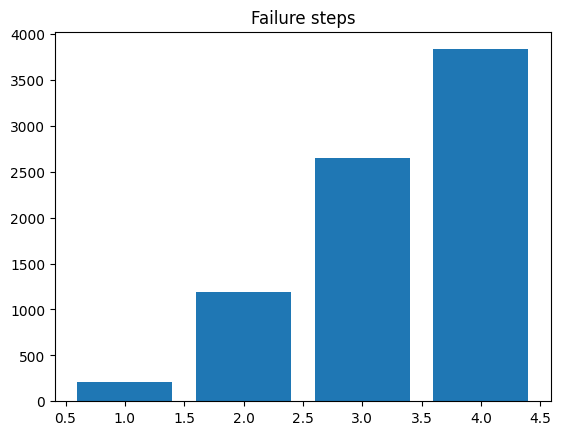

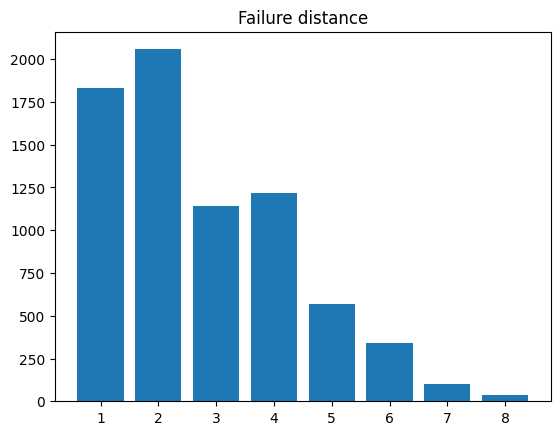

Total samples: 20000
Failures: 7886, error rate: 39.43%
--------------------
Trans hit rate: 41.20%
Obj hit rate: 79.98%
Action hit rate: 61.38%
--------------------
Loose failures: 587, percentage: 7.44%
Overlap failures: 3506, percentage: 44.46%
Move out failures: 60, percentage: 0.76%
--------------------
Set failures: 272, percentage: 3.45%
Object all correct failures: 2300, percentage: 29.17%
Action all correct failures: 817, percentage: 10.36%
--------------------
Small obj failures: 4481, percentage: 56.82%
Position failures: 6310, percentage: 80.02%
Non-position failures: 5061, percentage: 64.18%


In [3]:
PATH_EXP = Path("/log/exp/tvr/TRANCEDataModule.SubtractResNet.ReasonCriterion.2022-12-17_03-31-38/")
PATH_DETAIL = PATH_EXP / "detail.jsonl"
results = read_jsonlines(PATH_DETAIL)
results[0]
failures = [
    summary_result(result, dataset)
    for result in results
    if not result["correct"]
]
print("TranceNet-G")
print("--------------------")
summary = summary_failures(failures)

TranceNet-T
--------------------


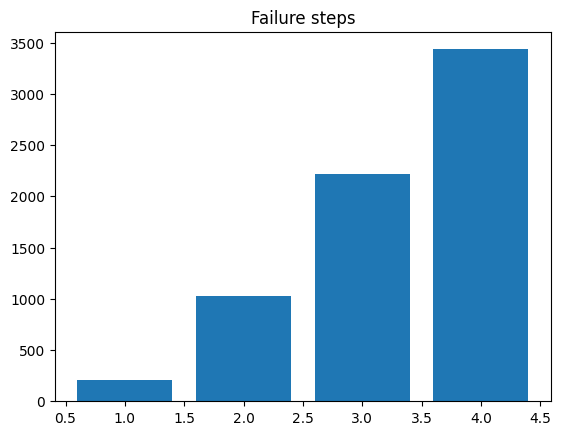

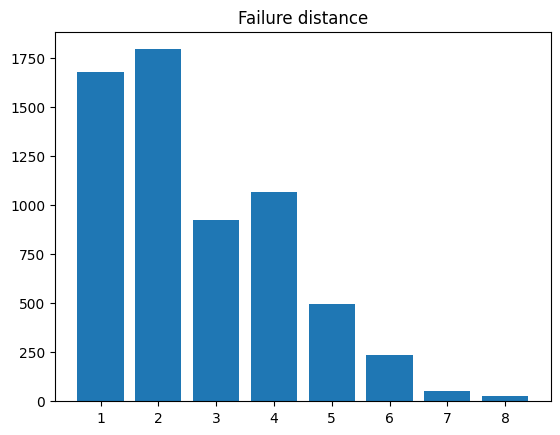

Total samples: 20000
Failures: 6894, error rate: 34.47%
--------------------
Trans hit rate: 42.84%
Obj hit rate: 82.07%
Action hit rate: 61.45%
--------------------
Loose failures: 624, percentage: 9.05%
Overlap failures: 3144, percentage: 45.60%
Move out failures: 47, percentage: 0.68%
--------------------
Set failures: 263, percentage: 3.81%
Object all correct failures: 2208, percentage: 32.03%
Action all correct failures: 708, percentage: 10.27%
--------------------
Small obj failures: 3793, percentage: 55.02%
Position failures: 5576, percentage: 80.88%
Non-position failures: 4283, percentage: 62.13%


In [6]:
PATH_EXP = Path("/log/exp/tvr/TRANCEDataModule.SubtractResNetFormer.ReasonCriterion.2022-12-22_22-38-40/")
PATH_DETAIL = PATH_EXP / "detail.jsonl"
results = read_jsonlines(PATH_DETAIL)
results[0]
failures = [
    summary_result(result, dataset)
    for result in results
    if not result["correct"]
]
print("TranceNet-T")
print("--------------------")
summary = summary_failures(failures)

In [11]:
set_failures = summary["set_failures"]

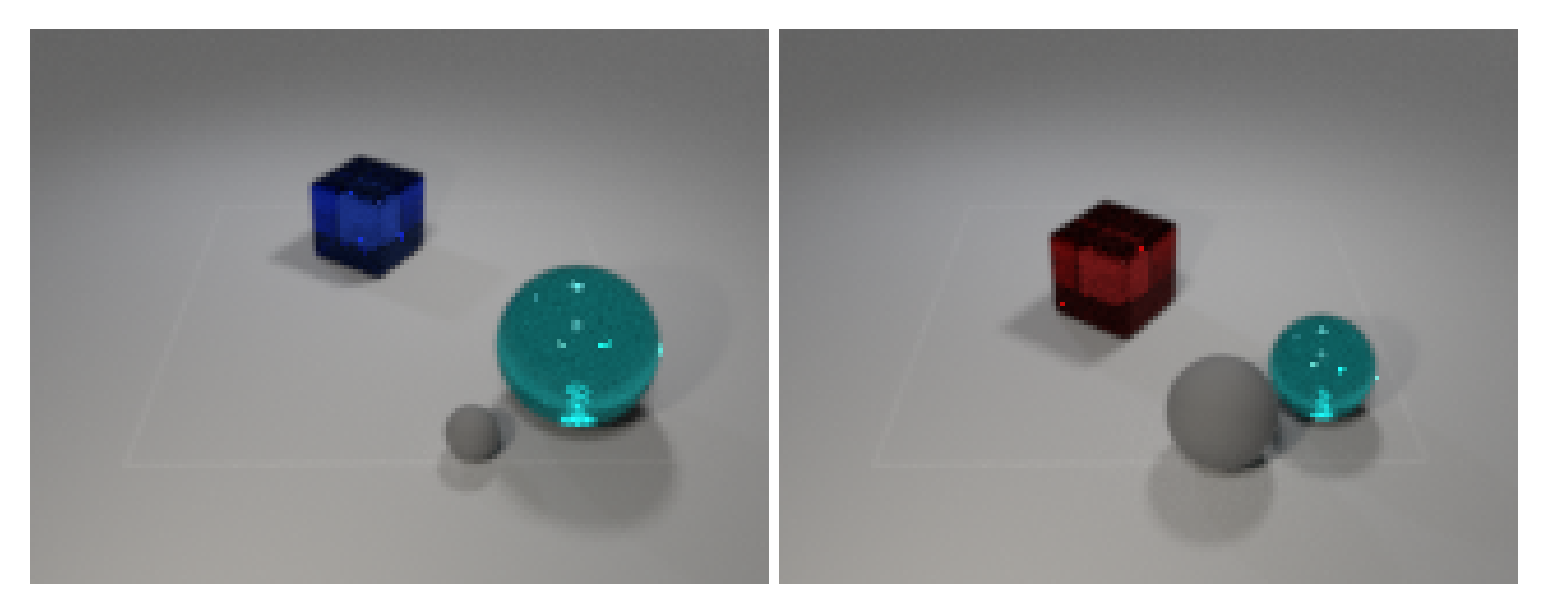

GT (4 steps):
- 2 size.medium
- 4 color.red
- 4 position.behind.1
- 7 size.medium
Pred (4 steps):
- 4 position.behind.1
- 7 size.medium
- 4 color.red
- 2 size.medium
--------------------
Index: 72
Distance: 0.0
Correct: False
Loose correct: True
--------------------
Hit rate: 1.0
Hit object rate: 1.0
Hit action rate: 1.0
--------------------
Overlap: True
Invalid Position: False
Object all correct failure: True
Action all correct failure: True
Set failure: True
Small object failure: False
Position failure: False
Non-position failure: False
--------------------


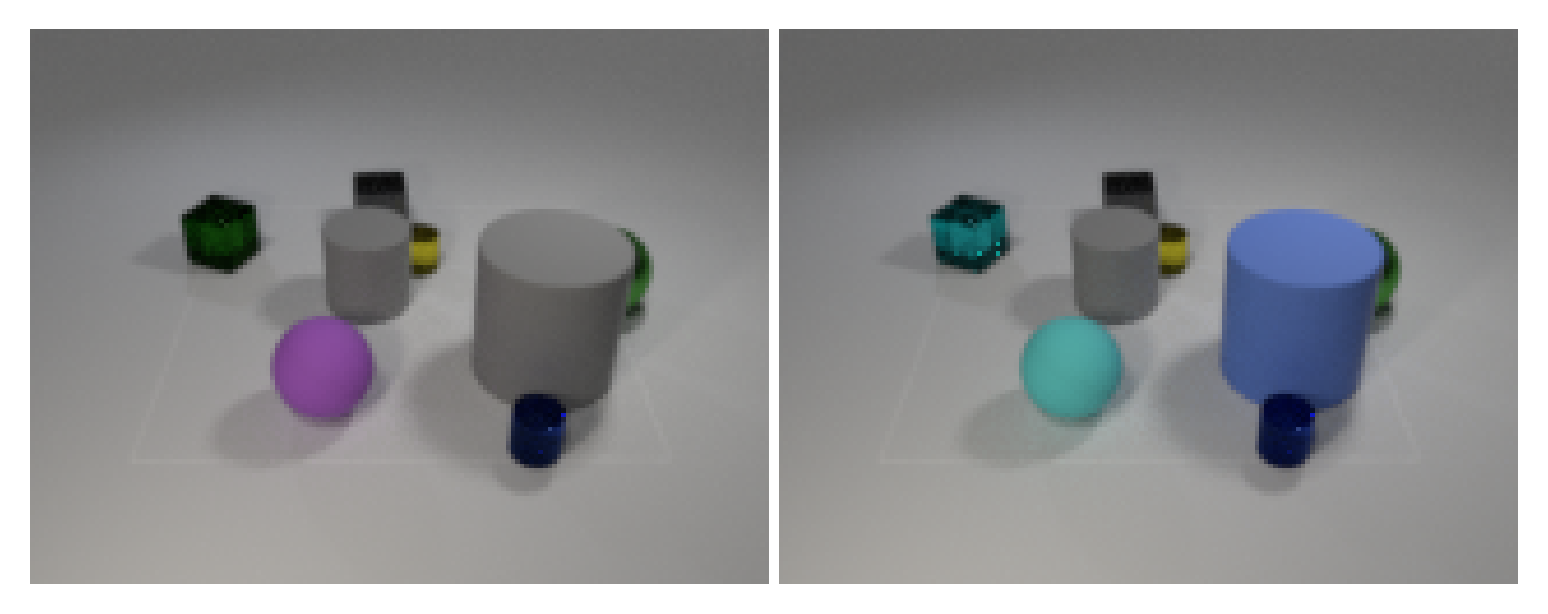

GT (3 steps):
- 6 color.cyan
- 8 color.cyan
- 5 color.blue
Pred (3 steps):
- 8 color.cyan
- 6 color.blue
- 5 color.cyan
--------------------
Index: 82
Distance: 2.0
Correct: False
Loose correct: False
--------------------
Hit rate: 0.3333333333333333
Hit object rate: 1.0
Hit action rate: 1.0
--------------------
Overlap: False
Invalid Position: False
Object all correct failure: True
Action all correct failure: True
Set failure: True
Small object failure: False
Position failure: False
Non-position failure: True
--------------------


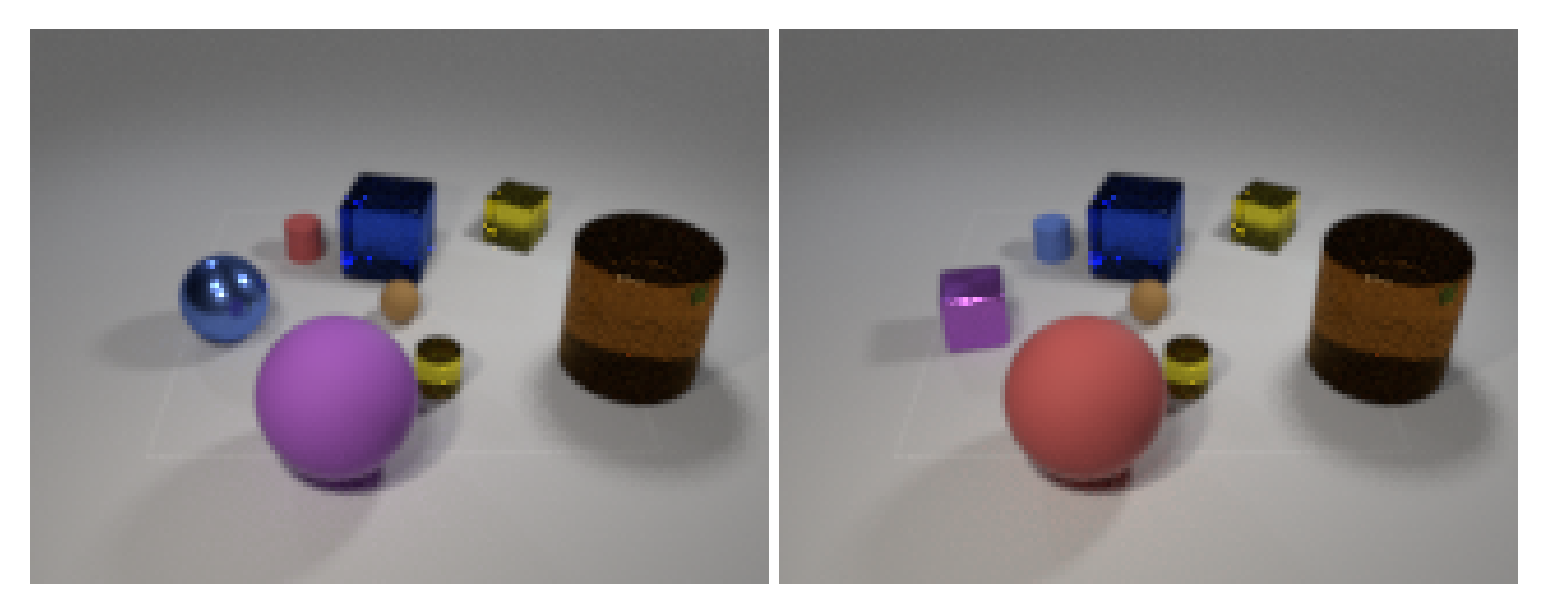

GT (4 steps):
- 6 shape.cube
- 0 color.blue
- 6 color.purple
- 1 color.red
Pred (4 steps):
- 6 color.red
- 0 color.blue
- 1 color.purple
- 6 shape.cube
--------------------
Index: 111
Distance: 2.0
Correct: False
Loose correct: False
--------------------
Hit rate: 0.5
Hit object rate: 1.0
Hit action rate: 1.0
--------------------
Overlap: False
Invalid Position: False
Object all correct failure: True
Action all correct failure: True
Set failure: True
Small object failure: False
Position failure: False
Non-position failure: True
--------------------


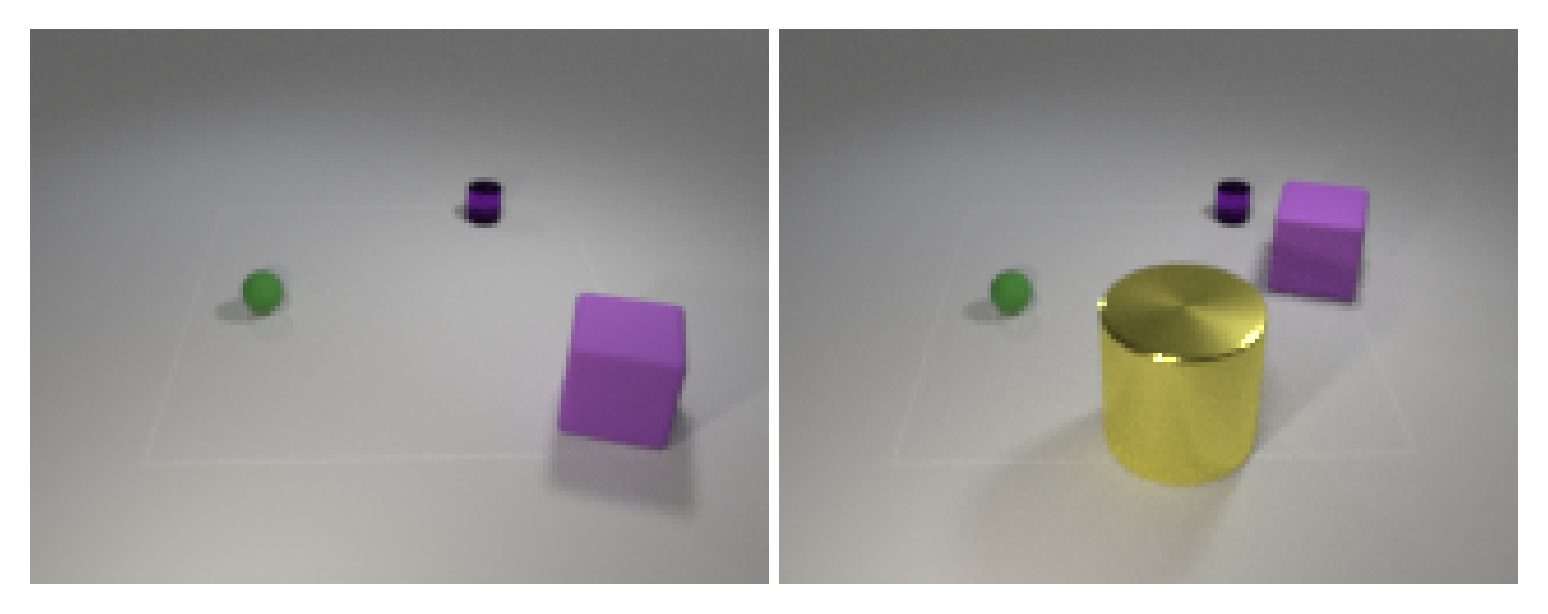

GT (3 steps):
- 0 position.behind-left.2
- 7 position.front.2
- 0 size.large
Pred (3 steps):
- 7 position.front.2
- 0 position.behind-left.2
- 0 size.large
--------------------
Index: 118
Distance: 0.0
Correct: False
Loose correct: True
--------------------
Hit rate: 1.0
Hit object rate: 1.0
Hit action rate: 1.0
--------------------
Overlap: True
Invalid Position: False
Object all correct failure: True
Action all correct failure: True
Set failure: True
Small object failure: False
Position failure: False
Non-position failure: False
--------------------


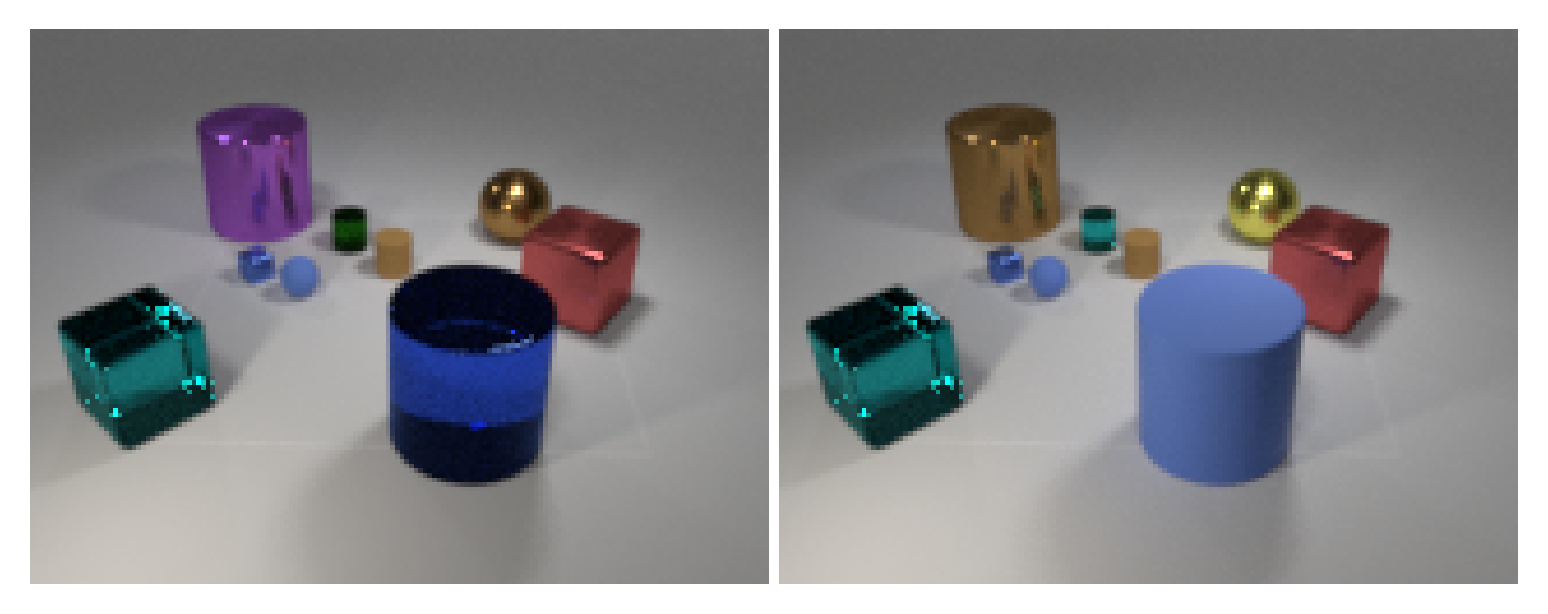

GT (4 steps):
- 5 color.cyan
- 4 material.rubber
- 8 color.brown
- 0 color.yellow
Pred (4 steps):
- 5 color.cyan
- 4 color.brown
- 0 color.yellow
- 8 material.rubber
--------------------
Index: 144
Distance: 4.0
Correct: False
Loose correct: False
--------------------
Hit rate: 0.5
Hit object rate: 1.0
Hit action rate: 1.0
--------------------
Overlap: False
Invalid Position: False
Object all correct failure: True
Action all correct failure: True
Set failure: True
Small object failure: False
Position failure: False
Non-position failure: True
--------------------


In [14]:

for i in range(5):
    visualize_result(results[set_failures[i]], dataset)